#  AtliQo Bank Credit Card Launch: Phase 1

Objective: Analyze customers' transactions and credit profiles to figure out a target group for the launch of AtliQo bank credit card

In [38]:
import pandas as pd
import mysql.connector
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


<h1 style="color:purple" align="center">Data Import<h1>

Read it from MySQL

In [39]:
conn = mysql.connector.connect(user = 'root',
password = 'root',
host = 'localhost',       # or IP address, e.g., '127.0.0.1'              # default MySQL port
database = 'e_master_card') 

<h1 style="color:purple" align="center">Explore Customers Table<h1>

In [225]:
df_cust = pd.read_sql('SELECT * FROM customers',conn) 

In [226]:
df_cust.head()

,cust_id,name,gender,age,location,occupation,annual_income,marital_status
0,1,Manya Acharya,Female,2,City,Business Owner,358211,Married
1,2,Anjali Pandey,Female,47,City,Consultant,65172,Single
2,3,Aaryan Chauhan,Male,21,City,Freelancer,22378,Married
3,4,Rudra Bali,Male,24,Rural,Freelancer,33563,Married
4,5,Advait Malik,Male,48,City,Consultant,39406,Married


In [227]:
df_tran = pd.read_sql('SELECT * FROM transactions',conn) 

In [228]:
df_tran.head() 

,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type
0,1,705,2023-01-01,63,Flipkart,Electronics,Phonepe
1,2,385,2023-01-01,99,Alibaba,Fashion & Apparel,Credit Card
2,3,924,2023-01-01,471,Shopify,Sports,Phonepe
3,4,797,2023-01-01,33,Shopify,Fashion & Apparel,Gpay
4,5,482,2023-01-01,68,Amazon,Fashion & Apparel,Net Banking


In [229]:
df_credit = pd.read_sql('SELECT * FROM credit_profiles',conn)

In [230]:
df_credit.head()

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit
0,1,749,0.585171,19571.0,0.0,40000.0
1,2,587,0.107928,161644.0,2.0,1250.0
2,3,544,0.854807,513.0,4.0,1000.0
3,4,504,0.336938,224.0,2.0,1000.0
4,5,708,0.586151,18090.0,2.0,40000.0


<h2 style="color:Blue">1. Analyze Income Column<h2>
Handle Null Values: Annual income
Now let us check if any of our dataframe columns contain null values

In [231]:
df_cust.isnull().sum()

cust_id           0
name              0
gender            0
age               0
location          0
occupation        0
annual_income     0
marital_status    0
dtype: int64

We can handle these null values using different ways,

1. **Remove them**: Since there are 50 of them in a dataframe of 1000, we will not remove them as we don't want to loose some important records
1. **Replace them with mean or median**: It is suggested with use median in the case of income. This is because in an income data there could be outliers and median is more robust to these outliers
1. **Replace them with median per occupation**: Occupation wise median income can vary. It is best to use a median per occupation for replacement

In [232]:
df_tran.isnull().sum()

tran_id                0
cust_id                0
tran_date              0
tran_amount            0
platform            4941
product_category       0
payment_type           0
dtype: int64

In [233]:
df_credit.isnull().sum() 

cust_id                            0
credit_score                       0
credit_utilisation                 4
outstanding_debt                   4
credit_inquiries_last_6_months     4
credit_limit                      69
dtype: int64

In [234]:
df_cust[df_cust['annual_income'] == 0].shape ##all these are values we need to treat 

(50, 8)

In [235]:
df_cust[df_cust['cust_id'] == 15]

,cust_id,name,gender,age,location,occupation,annual_income,marital_status
14,15,Sanjana Malik,Female,25,Rural,Artist,0,Married


In [236]:
df_credit[df_credit.isnull().any(axis=1)]
# 📌 .isnull() only detects:
# NaN (Not a Number)

# None (Python’s null)

# pd.NA (pandas nullable types)

# It does not treat:

# ' ' (space character)

# '' (empty string)
# as missing by default 

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit
10,11,679,0.557450,9187.0,2.0,NaN
35,36,790,0.112535,4261.0,1.0,NaN
37,38,514,0.296971,238.0,2.0,NaN
45,46,761,0.596041,24234.0,2.0,NaN
64,65,734,0.473715,13631.0,0.0,NaN
...,...,...,...,...,...,...
912,909,479,0.487555,320.0,3.0,NaN
931,928,311,0.832244,316.0,2.0,NaN
948,945,526,0.272734,227.0,1.0,NaN
954,951,513,0.175914,131.0,3.0,NaN


In [237]:
df_cust[df_cust.occupation == 'Artist'].annual_income.median()

np.float64(44915.0)

In [238]:
df_cust[df_cust.occupation == 'Data Scientist'].annual_income.median()

np.float64(127889.0)

In [239]:
df_cust[df_cust.occupation == 'Fullstack Developer'].annual_income.median()

np.float64(74457.0)

In [240]:
df_cust[df_cust.occupation == 'Business Owner'].annual_income.median() 

np.float64(254881.0)

In [241]:
occu = pd.read_sql('SELECT DISTINCT occupation FROM customers',conn)
occu 

,occupation
0,Business Owner
1,Consultant
2,Freelancer
3,Fullstack Developer
4,Accountant
5,Data Scientist
6,Artist


In [242]:
# occupation_wise_median = pd.read_sql('SELECT MEDIAN(annual_income) FROM customers GROUP BY occupations',conn) # this doesn't workss.......
# df_cust.groupby('occupation')['annual_income'].median()
occupation_wise_median = df_cust.groupby('occupation').annual_income.median()

In [243]:
occupation_wise_median

occupation
Accountant              65265.0
Artist                  44915.0
Business Owner         254881.0
Consultant              51175.0
Data Scientist         127889.0
Freelancer              45189.5
Fullstack Developer     74457.0
Name: annual_income, dtype: float64

In [244]:
occupation_wise_median['Fullstack Developer']
# This accesses the median annual income for the occupation 'Artist' from the Series created above.

np.float64(74457.0)

In [245]:
def get_median(row):
    if pd.isnull(row['annual_income']) or row['annual_income'] == 0:
        return occupation_wise_median[row['occupation']]
    else:
        return row['annual_income'] 


In [246]:
get_median({'cust_id':3425, 'occupation' : "Fullstack Developer" , "annual_income" : None}) 

np.float64(74457.0)

In [247]:
# df_cust['annual_income'] = df_cust.apply(get_median,axis=1)
# A shorter way is to apply Lambda
# lambda arguments: value_if_true if condition else value_if_false

df_cust['annual_income'] = df_cust.apply(lambda row: occupation_wise_median[row['occupation']] if pd.isnull(row['annual_income']) or row['annual_income'] == 0 else row['annual_income'] ,axis=1)

In [248]:
rows = df_cust[df_cust['annual_income'] == 0] 

In [249]:
rows.shape

(0, 8)

In [250]:
df_cust.isnull().sum()

cust_id           0
name              0
gender            0
age               0
location          0
occupation        0
annual_income     0
marital_status    0
dtype: int64

Awesome 😀 Number of null values in all the columns is zero now! Hurray 🥳

Now that there are no null values, let us view the distribution of annual income

In [251]:
df_cust[df_cust['cust_id'] == 25]

,cust_id,name,gender,age,location,occupation,annual_income,marital_status
24,25,Arnav Pandey,Male,29,City,Fullstack Developer,109158.0,Single


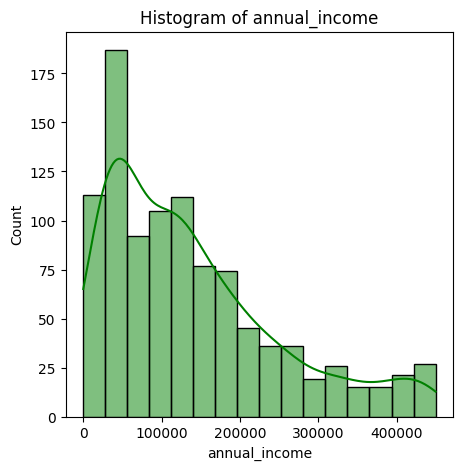

In [252]:
plt.figure(figsize=(5,5))
sns.histplot(df_cust['annual_income'],kde=True,color='green',label='Data')
plt.title("Histogram of annual_income")
plt.show() # right skewed plot

**You can see above that the income distribution is right skewed**

Let us now use describe() function to check some quick stats

We have following observations from the above,

1. **Age**: min = 1, max = 135
1. **Annual Income**: min = 2, max = 447 k

Age column has outliers. Annual income also seem to have outliers in terms of minimum value because business suggested that minimum income should be atleast 100

In [254]:
df_cust.describe()

,cust_id,age,annual_income
count,1000.000000,1000.000000,1000.000000
mean,500.500000,36.405000,138634.437500
std,288.819436,15.666155,110961.396638
min,1.000000,1.000000,2.000000
25%,250.750000,26.000000,48229.500000
50%,500.500000,32.000000,113416.000000
75%,750.250000,46.000000,192614.000000
max,1000.000000,135.000000,449346.000000


### Outlier Detection: Annual income

Let us use standard deviation to detect outliers. Common practice is to treat anything that +/- 3 std dev as an outlier

In [255]:
df_cust[df_cust.annual_income < 100] # these are invalid values 

,cust_id,name,gender,age,location,occupation,annual_income,marital_status
31,32,Veer Mistry,Male,50,City,Business Owner,50.0,Married
262,263,Vivaan Tandon,Male,53,Suburb,Business Owner,50.0,Married
316,317,Yuvraj Saxena,Male,47,City,Consultant,50.0,Married
333,334,Avani Khanna,Female,29,City,Data Scientist,50.0,Married
340,341,Priya Sinha,Female,33,Rural,Fullstack Developer,50.0,Married
543,544,Advait Batra,Male,54,City,Consultant,2.0,Married
592,593,Priya Gandhi,Female,32,City,Business Owner,50.0,Married
633,634,Rudra Mehtani,Male,26,City,Data Scientist,2.0,Married
686,687,Vihaan Jaiswal,Male,40,City,Business Owner,2.0,Married
696,697,Ishan Negi,Male,47,City,Consultant,20.0,Married


In [256]:
df_cust.at[4,"annual_income"]

np.float64(39406.0)

In [257]:
df_cust.iterrows

<bound method DataFrame.iterrows of      cust_id              name  gender  age location           occupation  \
0          1     Manya Acharya  Female    2     City       Business Owner   
1          2     Anjali Pandey  Female   47     City           Consultant   
2          3    Aaryan Chauhan    Male   21     City           Freelancer   
3          4        Rudra Bali    Male   24    Rural           Freelancer   
4          5      Advait Malik    Male   48     City           Consultant   
..       ...               ...     ...  ...      ...                  ...   
995      996    Manya Vasudeva  Female   26     City           Freelancer   
996      997      Aarav Dhawan    Male   55     City       Business Owner   
997      998         Rehan Jha    Male   29     City  Fullstack Developer   
998      999     Amara Rathore  Female   47     City       Business Owner   
999     1000  Akshay Choudhary    Male   28     City           Freelancer   

     annual_income marital_status  
0  

In [258]:
for index, row in df_cust.iterrows():
    if row['annual_income'] <100:
        df_cust.at[index,"annual_income"] = occupation_wise_median[row['occupation']] 

In [259]:
df_cust[df_cust.annual_income < 100] ##hurray

,cust_id,name,gender,age,location,occupation,annual_income,marital_status


In [260]:
df_cust.loc[[31,316]]

,cust_id,name,gender,age,location,occupation,annual_income,marital_status
31,32,Veer Mistry,Male,50,City,Business Owner,254881.0,Married
316,317,Yuvraj Saxena,Male,47,City,Consultant,51175.0,Married


# DATA VISUALIZATIONS EDA

In [262]:
occupation_wise_mean = df_cust.groupby('occupation').annual_income.mean()

In [263]:
occupation_wise_mean.index

Index(['Accountant', 'Artist', 'Business Owner', 'Consultant',
       'Data Scientist', 'Freelancer', 'Fullstack Developer'],
      dtype='object', name='occupation')

In [264]:
occupation_wise_mean.values

array([ 64123.5625    ,  45239.84210526, 268119.83391003,  59927.25773196,
       136208.60326087,  76293.08991228,  78618.38513514])

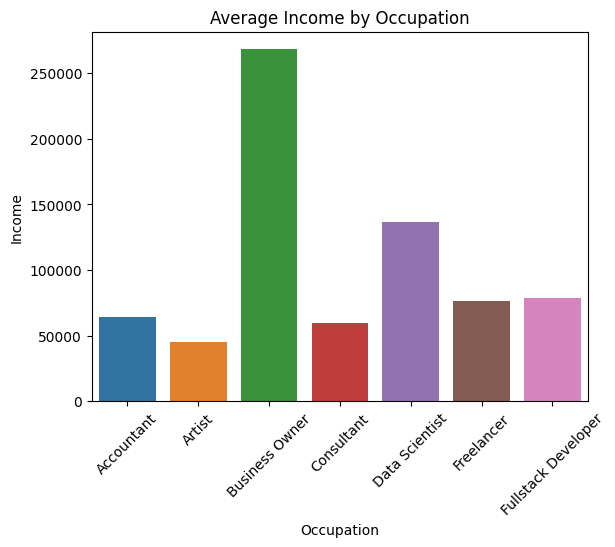

In [265]:
sns.barplot(x = occupation_wise_mean.index, y = occupation_wise_mean.values,palette='tab10')

plt.title("Average Income by Occupation")
plt.xlabel("Occupation")
plt.ylabel("Income")
plt.xticks(rotation=45)
plt.show() 

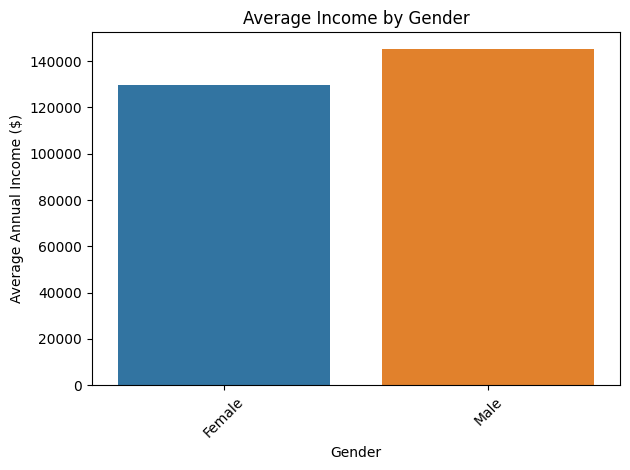

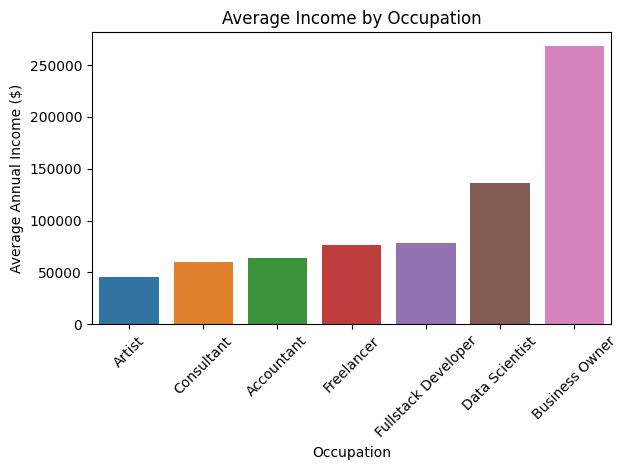

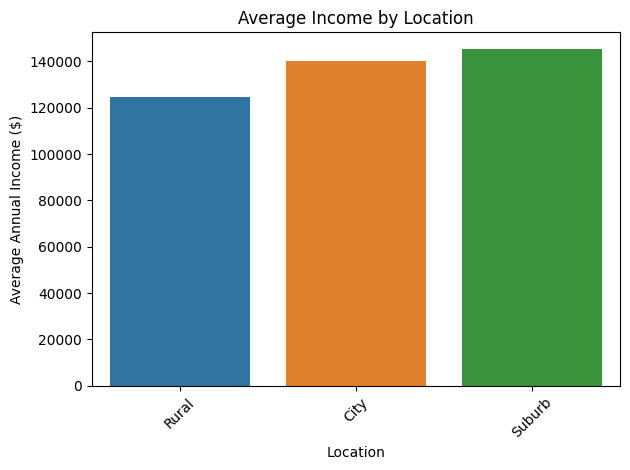

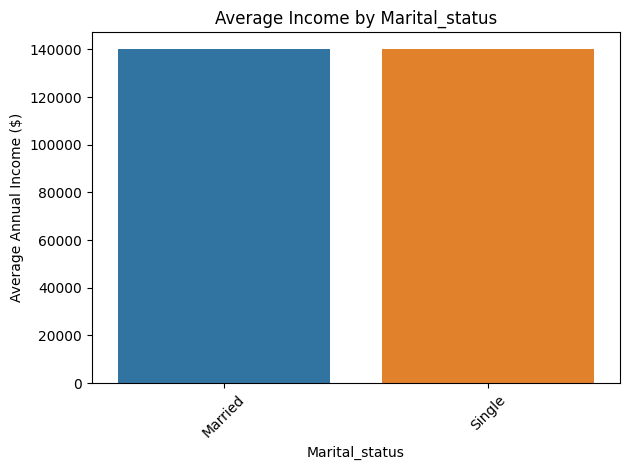

In [266]:
categorical_columns = ['gender', 'occupation', 'location', 'marital_status']

for col in categorical_columns:
    temp_mean = df_cust.groupby(col)['annual_income'].mean().sort_values()
    
    sns.barplot(x=temp_mean.index, y=temp_mean.values, palette='tab10')
    plt.title(f"Average Income by {col.capitalize()}")
    plt.xlabel(col.capitalize())
    plt.ylabel("Average Annual Income ($)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



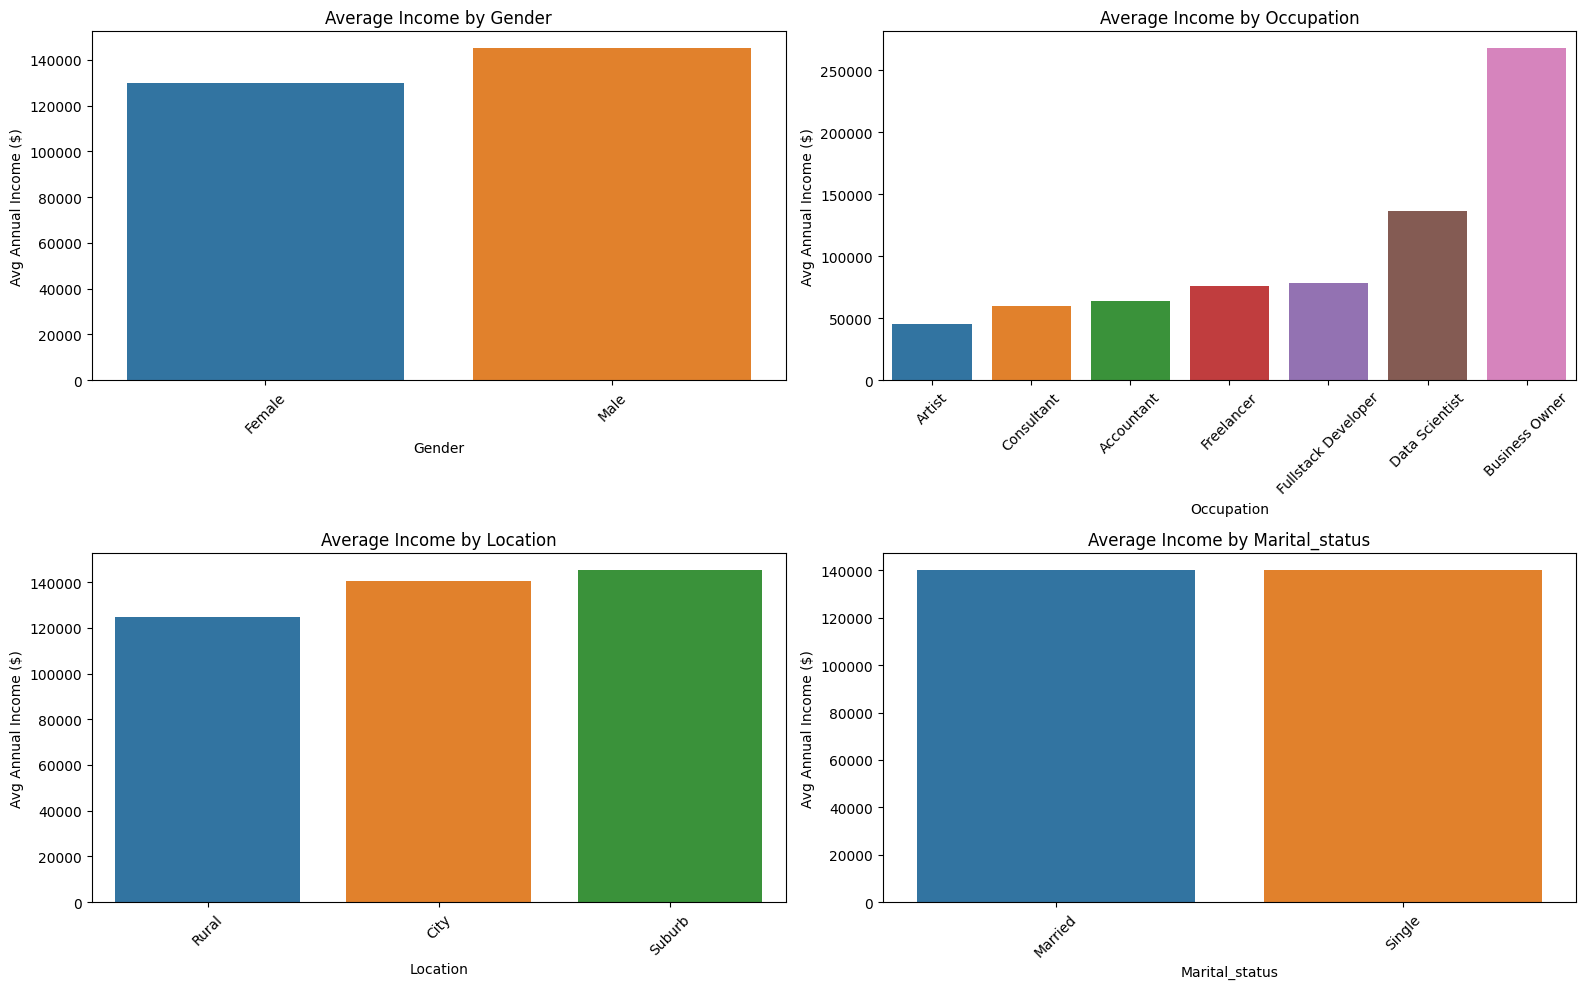

In [267]:
import matplotlib.pyplot as plt
import seaborn as sns

categorical_columns = ['gender', 'occupation', 'location', 'marital_status']

# Define number of subplots
n = len(categorical_columns)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))
axes = axes.flatten()  # Flatten 2D array of axes to 1D for easy iteration

for i, col in enumerate(categorical_columns):
    temp_mean = df_cust.groupby(col)['annual_income'].mean().sort_values()
    
    sns.barplot(x=temp_mean.index, y=temp_mean.values, palette='tab10', ax=axes[i])
    axes[i].set_title(f"Average Income by {col.capitalize()}")
    axes[i].set_xlabel(col.capitalize())
    axes[i].set_ylabel("Avg Annual Income ($)")
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [268]:
df_cust.describe()

,cust_id,age,annual_income
count,1000.000000,1000.000000,1000.000000
mean,500.500000,36.405000,140137.395500
std,288.819436,15.666155,110450.464107
min,1.000000,1.000000,5175.000000
25%,250.750000,26.000000,49620.500000
50%,500.500000,32.000000,115328.000000
75%,750.250000,46.000000,195514.250000
max,1000.000000,135.000000,449346.000000


In [269]:
df_cust[(df_cust['age'] < 15) | (df_cust['age'] > 80)]


,cust_id,name,gender,age,location,occupation,annual_income,marital_status
0,1,Manya Acharya,Female,2,City,Business Owner,358211.0,Married
41,42,Aaryan Shah,Male,110,City,Artist,7621.0,Married
165,166,Sia Dutta,Female,1,City,Freelancer,39721.0,Single
174,175,Rohan Sharma,Male,110,City,Freelancer,23723.0,Married
222,223,Arjun Batra,Male,110,Suburb,Freelancer,210987.0,Married
277,278,Aarav Tandon,Male,110,City,Consultant,96522.0,Single
295,296,Ayush Pandey,Male,1,Rural,Accountant,55254.0,Married
325,326,Virat Goel,Male,110,City,Accountant,61021.0,Single
610,611,Rehan Verma,Male,135,Rural,Business Owner,444776.0,Married
692,693,Dhruv Jha,Male,1,City,Business Owner,83045.0,Married


In [270]:
occupation_wise_median_age = df_cust.groupby('occupation').age.median() ##method to collect the group of some rows then on some column apply mean or median method

In [271]:
occupation_wise_median_age

occupation
Accountant             31.5
Artist                 26.0
Business Owner         51.0
Consultant             46.0
Data Scientist         32.0
Freelancer             24.0
Fullstack Developer    27.5
Name: age, dtype: float64

In [272]:
occupation_wise_median_age['Freelancer']

np.float64(24.0)

In [273]:
for index, row in df_cust.iterrows():
    if row['age'] < 15 or row['age'] > 80:
        df_cust.at[index, "age"] = occupation_wise_median_age.get(row['occupation']) 


In [274]:
df_cust[(df_cust['age'] < 15) | (df_cust['age'] > 80)]

,cust_id,name,gender,age,location,occupation,annual_income,marital_status


In [275]:
df_cust.loc[[0,41,165,174,222,277,295,325]]

,cust_id,name,gender,age,location,occupation,annual_income,marital_status
0,1,Manya Acharya,Female,51.0,City,Business Owner,358211.0,Married
41,42,Aaryan Shah,Male,26.0,City,Artist,7621.0,Married
165,166,Sia Dutta,Female,24.0,City,Freelancer,39721.0,Single
174,175,Rohan Sharma,Male,24.0,City,Freelancer,23723.0,Married
222,223,Arjun Batra,Male,24.0,Suburb,Freelancer,210987.0,Married
277,278,Aarav Tandon,Male,46.0,City,Consultant,96522.0,Single
295,296,Ayush Pandey,Male,31.5,Rural,Accountant,55254.0,Married
325,326,Virat Goel,Male,31.5,City,Accountant,61021.0,Single


In [276]:
df_cust.age.describe()

count    1000.000000
mean       35.541500
std        12.276634
min        18.000000
25%        26.000000
50%        32.000000
75%        44.250000
max        64.000000
Name: age, dtype: float64

(array([441., 253., 171., 135.]),
 array([18. , 29.5, 41. , 52.5, 64. ]),
 <BarContainer object of 4 artists>)

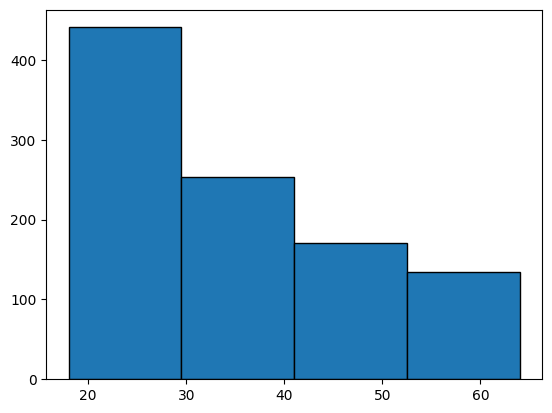

In [277]:
plt.hist(df_cust['age'] , bins = 4,edgecolor='black')
# Plotting a basic histogram
# plt.hist(data, bins=30, color='skyblue', edgecolor='black') 

In [278]:
# Define age bins and labels
age_bins = [(18, 25), (26, 35), (36, 48), (49, 80)]
age_labels = ['18-25', '26-35', '36-48', '49-80']

# Loop through each age group
for (lower, upper), label in zip(age_bins, age_labels):
    # Filter records in the age group
    group_df = df_cust[(df_cust['age'] >= lower) & (df_cust['age'] <= upper)]
    
    # Print header
    print(f"\nAge Group: {label}")
    print(f"Total Records: {len(group_df)}")
    
    # Print the actual records
    print(group_df)



Age Group: 18-25
Total Records: 246
     cust_id              name  gender   age location           occupation  \
2          3    Aaryan Chauhan    Male  21.0     City           Freelancer   
3          4        Rudra Bali    Male  24.0    Rural           Freelancer   
5          6          Arya Das    Male  22.0     City           Freelancer   
8          9    Vihaan Agarwal    Male  21.0   Suburb  Fullstack Developer   
9         10  Aditya Choudhary    Male  25.0    Rural           Freelancer   
..       ...               ...     ...   ...      ...                  ...   
973      974    Pranav Rastogi    Male  21.0     City           Freelancer   
980      981      Aahan Wadhwa    Male  24.0    Rural  Fullstack Developer   
982      983         Dhruv Sen    Male  25.0   Suburb       Data Scientist   
983      984      Zara Chauhan  Female  20.0     City  Fullstack Developer   
986      987       Avani Yadav  Female  20.0     City  Fullstack Developer   

     annual_income marital

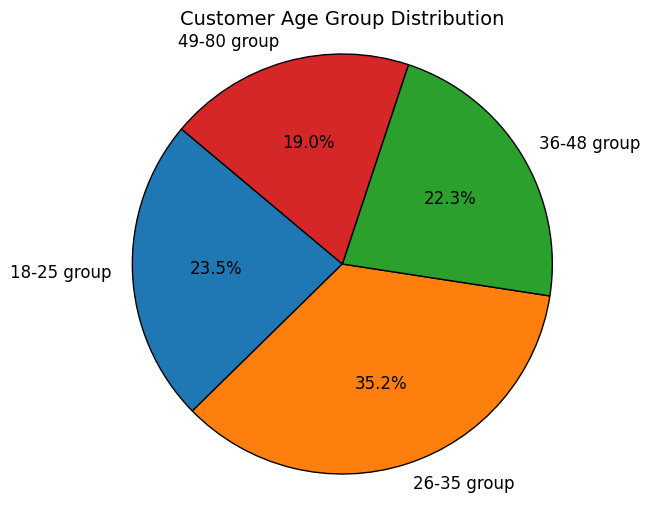

In [279]:
import matplotlib.pyplot as plt

# Define bins and labels
age_bins = [18, 25, 35, 48, 80]
age_labels = ['18-25 group', '26-35 group', '36-48 group', '49-80 group']

# Cut the 'age' column into age groups
df_cust['age_group'] = pd.cut(df_cust['age'], bins=age_bins, labels=age_labels, right=True)

# Count records in each group
age_group_counts = df_cust['age_group'].value_counts().sort_index()

# Plot pie chart
plt.figure(figsize=(8, 6))
plt.pie(
    age_group_counts,
    labels=age_group_counts.index,
    autopct='%1.1f%%',       # Show percentage inside slices
    startangle=140,
    textprops={'fontsize': 12},
    wedgeprops={'edgecolor': 'black'}
)

plt.title('Customer Age Group Distribution', fontsize=14)
plt.axis('equal')  # Ensures pie is a circle
plt.show()


### We can conclude that we have more number of customers in the age group of 26-35 

In [280]:
gender_location_counts = df_cust.groupby(['location', 'gender']).size().unstack(fill_value=0)


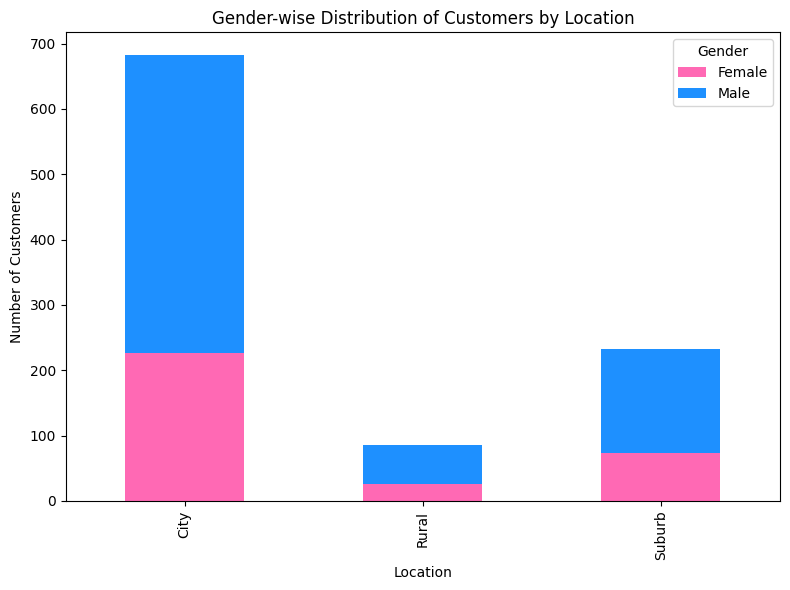

In [281]:
import matplotlib.pyplot as plt

# Plot
gender_location_counts.plot(kind='bar', stacked=True, figsize=(8, 6), color=['#FF69B4', '#1E90FF']  )

# Add titles and labels
plt.title('Gender-wise Distribution of Customers by Location')
plt.xlabel('Location')
plt.ylabel('Number of Customers')
plt.legend(title='Gender')
plt.tight_layout()
plt.show()


### We can see less number of females working >>>>>

<b><div style="text-align: center; color: purple; font-size: 29px;">
    EDA of Credit Score Table!
</div>
</div></b>


In [282]:
df_credit.head()

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit
0,1,749,0.585171,19571.0,0.0,40000.0
1,2,587,0.107928,161644.0,2.0,1250.0
2,3,544,0.854807,513.0,4.0,1000.0
3,4,504,0.336938,224.0,2.0,1000.0
4,5,708,0.586151,18090.0,2.0,40000.0


In [283]:
df_credit.shape

(1004, 6)

### But we have only 1000 entries in the customer table ... how did we get 1004 in the credit_score table ??? there might be some duplicate entries

In [284]:
df_credit['cust_id'].nunique()


1000

In [285]:
df_credit['cust_id'].duplicated().sum()

np.int64(4)

In [286]:
df_credit[df_credit['cust_id'].duplicated()]

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit
517,517,308,0.113860,33.0,3.0,500.0
570,569,344,0.112599,37.0,0.0,500.0
608,606,734,0.193418,4392.0,1.0,40000.0
665,662,442,0.856039,266.0,2.0,500.0


In [287]:
df_credit[df_credit.duplicated(keep=False)]

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit


In [288]:
df_credit.shape

(1004, 6)

In [289]:
df_credit[df_credit['cust_id'].duplicated(keep=False)]
# is showing no rows, that means there are no fully duplicated rows across all columns in df_credit.

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit
516,517,308,NaN,NaN,NaN,NaN
517,517,308,0.113860,33.0,3.0,500.0
569,569,344,NaN,NaN,NaN,NaN
570,569,344,0.112599,37.0,0.0,500.0
607,606,734,NaN,NaN,NaN,NaN
608,606,734,0.193418,4392.0,1.0,40000.0
664,662,442,NaN,NaN,NaN,NaN
665,662,442,0.856039,266.0,2.0,500.0


In [290]:
df_credit.drop_duplicates(subset='cust_id', keep='last', inplace=True)



In [291]:
df_credit.shape

(1000, 6)

In [292]:
df_credit[df_credit['cust_id'].duplicated(keep=False)]

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit


In [293]:
df_credit['cust_id'].nunique()

1000

In [294]:
df_credit.iloc[[516,569,607,664,665]]

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit
517,517,308,0.113860,33.0,3.0,500.0
571,570,334,0.406265,102.0,3.0,500.0
610,608,724,0.788290,16699.0,3.0,40000.0
668,665,388,0.117471,43.0,3.0,500.0
669,666,552,0.654303,563.0,3.0,1250.0


In [295]:
df_credit.columns


Index(['cust_id', 'credit_score', 'credit_utilisation', 'outstanding_debt',
       'credit_inquiries_last_6_months', 'credit_limit'],
      dtype='object')

In [296]:
df_credit.index


Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
       ...
        994,  995,  996,  997,  998,  999, 1000, 1001, 1002, 1003],
      dtype='int64', length=1000)

In [297]:
df_credit.reset_index(drop=True, inplace=True)


In [298]:
df_credit.index

RangeIndex(start=0, stop=1000, step=1)

In [299]:
df_credit.iloc[[516,569,607,664,665]]

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit
516,517,308,0.113860,33.0,3.0,500.0
569,570,334,0.406265,102.0,3.0,500.0
607,608,724,0.788290,16699.0,3.0,40000.0
664,665,388,0.117471,43.0,3.0,500.0
665,666,552,0.654303,563.0,3.0,1250.0


In [300]:
df_credit.isnull().sum()

cust_id                            0
credit_score                       0
credit_utilisation                 0
outstanding_debt                   0
credit_inquiries_last_6_months     0
credit_limit                      65
dtype: int64

In [301]:
df_credit.credit_limit.value_counts()

credit_limit
500.0      229
60000.0    186
40000.0    137
1500.0     100
1000.0      90
750.0       76
1250.0      75
20000.0     42
Name: count, dtype: int64

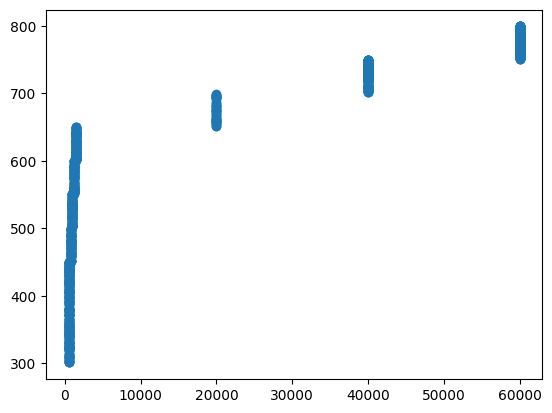

In [302]:
plt.scatter(df_credit.credit_limit,df_credit.credit_score)

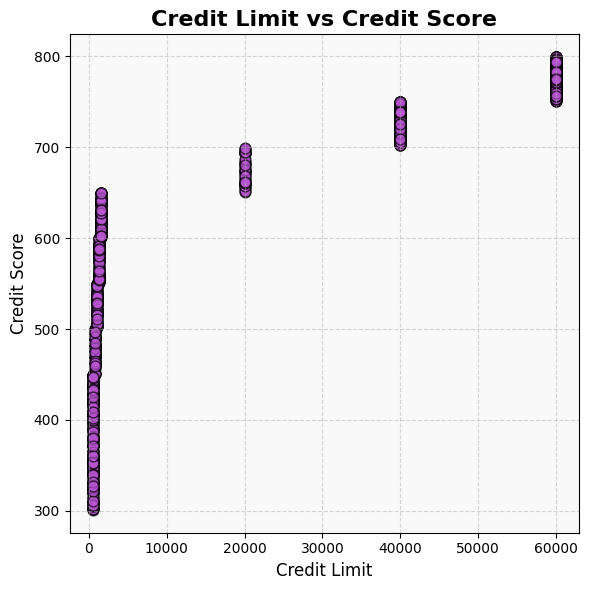

In [303]:



plt.figure(figsize=(6, 6))

# Create scatter plot
plt.scatter(
    df_credit['credit_limit'],
    df_credit['credit_score'],
    c='mediumorchid',         # purple color
    edgecolor='black',
    s=60,                     # marker size
    alpha=0.7                 # transparency
)

# Add labels and title
plt.title('Credit Limit vs Credit Score', fontsize=16, fontweight='bold')
plt.xlabel('Credit Limit', fontsize=12)
plt.ylabel('Credit Score', fontsize=12)

# Add grid
plt.grid(True, linestyle='--', alpha=0.5)

# Add axis ticks styling
plt.tick_params(axis='both', which='major', labelsize=10)

# Optional: add background color
plt.gca().set_facecolor('#f9f9f9')

# Show plot
plt.tight_layout()
plt.show()



In [304]:
df_credit.credit_score.value_counts()

credit_score
799    8
736    8
771    8
781    7
764    7
      ..
644    1
745    1
511    1
782    1
564    1
Name: count, Length: 419, dtype: int64

In [305]:
df_credit['credit_score'].min()

np.int64(300)

In [306]:

df_credit['credit_score'].max()


np.int64(799)

In [307]:
# Define bins and labels
credit_bins = [300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800]

credit_labels = [f"[{credit_bins[i]}-{credit_bins[i+1]-1}]" for i in range(len(credit_bins) - 1)]


# Count records in each group
df_credit['credit_score_labels'] = pd.cut(
    df_credit['credit_score'],
    bins=credit_bins,
    labels=credit_labels,
    right=True,
    include_lowest=True
)


In [308]:
df_credit.head()

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_score_labels
0,1,749,0.585171,19571.0,0.0,40000.0,[700-749]
1,2,587,0.107928,161644.0,2.0,1250.0,[550-599]
2,3,544,0.854807,513.0,4.0,1000.0,[500-549]
3,4,504,0.336938,224.0,2.0,1000.0,[500-549]
4,5,708,0.586151,18090.0,2.0,40000.0,[700-749]


In [309]:
df_credit.groupby("credit_score_labels")["credit_limit"].median()

credit_score_labels
[300-349]      500.0
[350-399]      500.0
[400-449]      500.0
[450-499]      750.0
[500-549]     1000.0
[550-599]     1250.0
[600-649]     1500.0
[650-699]    20000.0
[700-749]    40000.0
[750-799]    60000.0
Name: credit_limit, dtype: float64

Breakdown of Functionality:
df_credit.groupby("credit_score_labels")
This groups the DataFrame rows based on the values in the credit_score_labels column.
So all customers who fall into the same credit score range (e.g., [300–349], [350–399], etc.) are grouped together.

["credit_limit"]
After grouping, you select only the credit_limit column to perform operations on.

.median()
Calculates the median (middle value) of the credit_limit within each group defined by the credit score bins.

In [310]:
mode_df = df_credit.groupby("credit_score_labels")["credit_limit"].agg(lambda x: x.mode().iloc[0]).reset_index()

df_credit.groupby("credit_score_labels")
Groups the DataFrame by the credit_score_labels column (credit score bins like [300–349], [350–399], etc.).

["credit_limit"]
Selects the credit_limit column within each group.

.agg(lambda x: x.mode().iloc[0])
Applies a custom aggregation function using lambda.

x is the group of values from the credit_limit column.

x.mode() computes the mode(s) of the group (i.e., the most frequently occurring value(s)).

.iloc[0] takes the first mode if there are multiple.

In [311]:
mode_df

,credit_score_labels,credit_limit
0,[300-349],500.0
1,[350-399],500.0
2,[400-449],500.0
3,[450-499],750.0
4,[500-549],1000.0
5,[550-599],1250.0
6,[600-649],1500.0
7,[650-699],20000.0
8,[700-749],40000.0
9,[750-799],60000.0


In [312]:
df_credit_new = pd.merge(df_credit,mode_df,on = "credit_score_labels",suffixes=("", "_mode"))

In [313]:
df_credit_new.sample(3)

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_score_labels,credit_limit_mode
287,288,490,0.614912,385.0,2.0,750.0,[450-499],750.0
640,641,459,0.403866,190.0,4.0,750.0,[450-499],750.0
385,386,405,0.472900,182.0,1.0,500.0,[400-449],500.0


In [314]:
df_credit_new[df_credit_new.credit_limit.isnull()].sample(3)

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_score_labels,credit_limit_mode
686,687,736,0.738382,17882.0,3.0,NaN,[700-749],40000.0
342,343,733,0.646581,20948.0,2.0,NaN,[700-749],40000.0
953,954,783,0.867421,46451.0,0.0,NaN,[750-799],60000.0


In [315]:
df_credit_new.credit_limit.fillna(df_credit_new['credit_limit_mode'],inplace = True)

In [316]:
df_credit_new[df_credit_new.credit_limit.isnull()].sample(3)

ValueError: a must be greater than 0 unless no samples are taken

In [326]:
df_credit_new.iloc[[342,686,953]]

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_score_labels,credit_limit_mode
342,343,733,0.646581,20948.0,2.0,40000.0,[700-749],40000.0
686,687,736,0.738382,17882.0,3.0,40000.0,[700-749],40000.0
953,954,783,0.867421,46451.0,0.0,60000.0,[750-799],60000.0


In [317]:
df_credit_new.shape

(1000, 8)

In [319]:
missing_index = df_credit.index.difference(df_credit_new.index)


In [320]:
df_credit.loc[missing_index]


,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_score_labels


In [321]:
df_credit[df_credit['credit_score_labels'].isna()]
# It should return an empty DataFrame, meaning no rows are left unbinned.

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_score_labels


In [327]:
df_credit_new.isnull().sum()

cust_id                           0
credit_score                      0
credit_utilisation                0
outstanding_debt                  0
credit_inquiries_last_6_months    0
credit_limit                      0
credit_score_labels               0
credit_limit_mode                 0
dtype: int64

In [328]:
df_credit_new

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_score_labels,credit_limit_mode
0,1,749,0.585171,19571.0,0.0,40000.0,[700-749],40000.0
1,2,587,0.107928,161644.0,2.0,1250.0,[550-599],1250.0
2,3,544,0.854807,513.0,4.0,1000.0,[500-549],1000.0
3,4,504,0.336938,224.0,2.0,1000.0,[500-549],1000.0
4,5,708,0.586151,18090.0,2.0,40000.0,[700-749],40000.0
...,...,...,...,...,...,...,...,...
995,996,564,0.702963,688.0,2.0,1250.0,[550-599],1250.0
996,997,774,0.465462,17139.0,0.0,60000.0,[750-799],60000.0
997,998,529,0.585856,386.0,3.0,1000.0,[500-549],1000.0
998,999,725,0.249670,6973.0,2.0,40000.0,[700-749],40000.0


In [329]:
df_credit_new.describe()

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_limit_mode
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,500.500000,589.182000,0.498950,9683.597000,1.955000,19733.500000,19733.500000
std,288.819436,152.284929,0.233139,25255.893671,1.414559,24717.629112,24717.629112
min,1.000000,300.000000,0.103761,33.000000,0.000000,500.000000,500.000000
25%,250.750000,460.000000,0.293917,221.000000,1.000000,750.000000,750.000000
50%,500.500000,601.500000,0.487422,550.000000,2.000000,1500.000000,1500.000000
75%,750.250000,738.000000,0.697829,11819.500000,3.000000,40000.000000,40000.000000
max,1000.000000,799.000000,0.899648,209901.000000,4.000000,60000.000000,60000.000000


In [334]:
df_credit_new.outstanding_debt.isnull().sum()

np.int64(0)

<Axes: xlabel='outstanding_debt'>

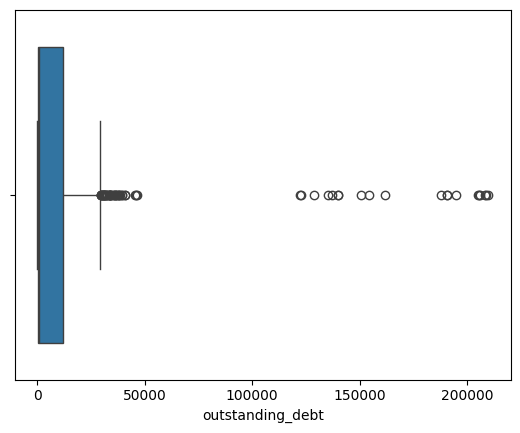

In [336]:
sns.boxplot(x= df_credit_new.outstanding_debt)

In [337]:
# your debt can not be more than yor credit limit .....
df_credit_new[df_credit_new.outstanding_debt > df_credit.credit_limit ]

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_score_labels,credit_limit_mode
1,2,587,0.107928,161644.0,2.0,1250.0,[550-599],1250.0
19,20,647,0.439132,205014.0,3.0,1500.0,[600-649],1500.0
25,26,758,0.250811,190838.0,2.0,60000.0,[750-799],60000.0
38,39,734,0.573023,122758.0,3.0,40000.0,[700-749],40000.0
93,94,737,0.739948,137058.0,2.0,40000.0,[700-749],40000.0
204,205,303,0.364360,187849.0,0.0,500.0,[300-349],500.0
271,272,703,0.446886,154568.0,1.0,40000.0,[700-749],40000.0
330,331,799,0.363420,208898.0,4.0,60000.0,[750-799],60000.0
350,351,320,0.285081,150860.0,0.0,500.0,[300-349],500.0
446,447,754,0.178394,206191.0,2.0,60000.0,[750-799],60000.0


In [339]:
df_credit_new.loc[df_credit_new.outstanding_debt > df_credit.credit_limit, 'outstanding_debt'] = df_credit_new.credit_limit

In [340]:
df_credit_new.loc[df_credit_new.outstanding_debt > df_credit.credit_limit, 'outstanding_debt']

Series([], Name: outstanding_debt, dtype: float64)

In [341]:
df_credit_new.loc[df_credit_new.outstanding_debt > df_credit.credit_limit]

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_score_labels,credit_limit_mode


In [343]:
df_credit_new.loc[[1,19,25,38]]

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_score_labels,credit_limit_mode
1,2,587,0.107928,1250.0,2.0,1250.0,[550-599],1250.0
19,20,647,0.439132,1500.0,3.0,1500.0,[600-649],1500.0
25,26,758,0.250811,60000.0,2.0,60000.0,[750-799],60000.0
38,39,734,0.573023,40000.0,3.0,40000.0,[700-749],40000.0


In [345]:
df_merge = df_cust.merge(df_credit_new,on = "cust_id", how = "inner")

In [350]:
numerical_columns = ["credit_score","credit_limit","outstanding_debt","credit_inquiries_last_6_months","credit_utilisation","annual_income","age"]
correlation_matrix = df_merge[numerical_columns].corr() ## Its a strong correlation
correlation_matrix

,credit_score,credit_limit,outstanding_debt,credit_inquiries_last_6_months,credit_utilisation,annual_income,age
credit_score,1.000000,0.847951,0.584742,-0.001226,-0.070445,0.575685,0.444917
credit_limit,0.847951,1.000000,0.690619,0.014716,-0.080504,0.684633,0.510980
outstanding_debt,0.584742,0.690619,1.000000,0.044420,0.143456,0.474981,0.408891
credit_inquiries_last_6_months,-0.001226,0.014716,0.044420,1.000000,-0.013952,0.002748,-0.025831
credit_utilisation,-0.070445,-0.080504,0.143456,-0.013952,1.000000,-0.086816,-0.027713
annual_income,0.575685,0.684633,0.474981,0.002748,-0.086816,1.000000,0.618136
age,0.444917,0.510980,0.408891,-0.025831,-0.027713,0.618136,1.000000


<Axes: >

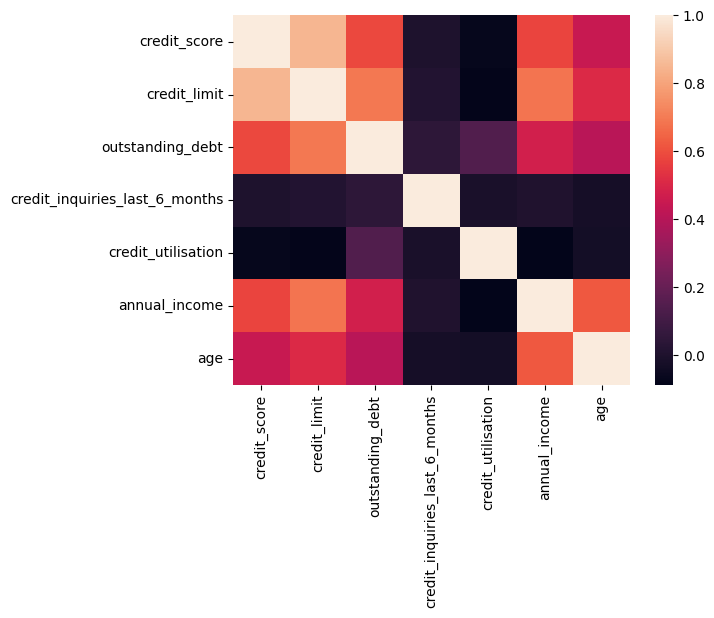

In [351]:
sns.heatmap(correlation_matrix)

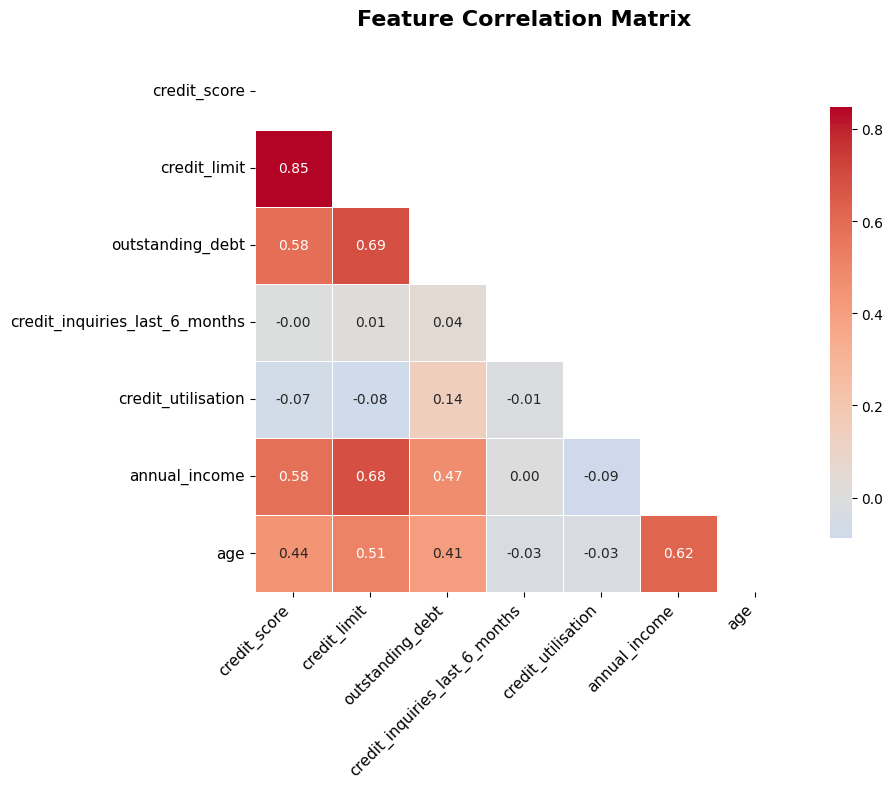

In [353]:
import numpy as np
# 1) Set up the figure
fig, ax = plt.subplots(figsize=(10, 8))

# 2) Create a mask for the upper triangle (optional, to avoid redundant info)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# 3) Draw the heatmap
sns.heatmap(
    correlation_matrix,
    mask=mask,
    annot=True,               # show the correlation values
    fmt=".2f",                # two decimal places
    cmap="coolwarm",          # diverging palette (blue↔red)
    center=0,                 # center the colormap at zero
    square=True,              # force each cell to be square
    linewidths=0.5,           # thin lines between cells
    cbar_kws={"shrink": .8},  # make colorbar smaller
    annot_kws={"size": 10},   # annotation font size
    ax=ax
)

# 4) Tweak the axes
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=11)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=11)

# 5) Add a title
ax.set_title("Feature Correlation Matrix", fontsize=16, fontweight="bold", pad=20)

plt.tight_layout()
plt.show()

<div style="
     font-size: 28px;
     color: white;
     background-color: #4a90e2;
     padding: 8px 12px;
     border-radius: 4px;
     display: inline-block;
">
  <b>Transaction Table</b>
</div>


In [354]:
df_tran.head()

,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type
0,1,705,2023-01-01,63,Flipkart,Electronics,Phonepe
1,2,385,2023-01-01,99,Alibaba,Fashion & Apparel,Credit Card
2,3,924,2023-01-01,471,Shopify,Sports,Phonepe
3,4,797,2023-01-01,33,Shopify,Fashion & Apparel,Gpay
4,5,482,2023-01-01,68,Amazon,Fashion & Apparel,Net Banking


In [355]:
df_tran.platform.isnull().sum()

np.int64(4941)

In [356]:
df_tran.platform.unique()

array(['Flipkart', 'Alibaba', 'Shopify', 'Amazon', 'Ebay', 'Meesho',
       'Cred', None], dtype=object)

In [358]:
df_tran[df_tran.platform.isnull()]

,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type
355,356,58,2023-01-01,237,None,Electronics,Net Banking
418,419,383,2023-01-01,338,None,Electronics,Credit Card
607,608,421,2023-01-01,700,None,Electronics,Phonepe
844,845,945,2023-01-01,493,None,Sports,Credit Card
912,913,384,2023-01-01,85,None,Fashion & Apparel,Phonepe
...,...,...,...,...,...,...,...
499579,499580,924,2023-09-05,31,None,Fashion & Apparel,Gpay
499646,499647,944,2023-09-05,58445,None,Fashion & Apparel,Phonepe
499725,499726,620,2023-09-05,15,None,Sports,Net Banking
499833,499834,616,2023-09-05,97,None,Fashion & Apparel,Credit Card


In [359]:
df_tran[df_tran.platform.isnull()].groupby('product_category')

<Axes: xlabel='count', ylabel='platform'>

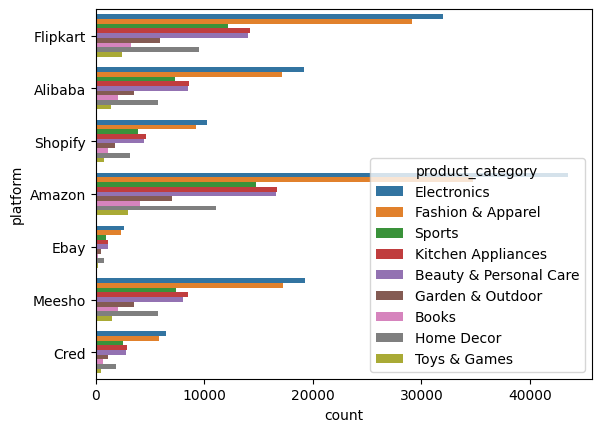

In [361]:
sns.countplot(y= "platform", hue = "product_category",data = df_tran )

<Axes: xlabel='count', ylabel='product_category'>

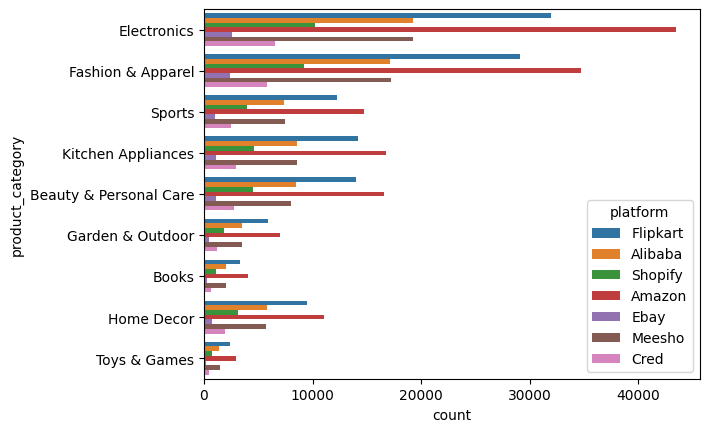

In [362]:
sns.countplot(y= "product_category", hue = "platform",data = df_tran )

In [363]:
df_tran.platform.mode()[0]

'Amazon'

In [365]:
df_tran.platform.fillna(df_tran.platform.mode()[0],inplace=True)

In [366]:
df_tran[df_tran.platform.isnull()]

,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type


In [367]:
df_tran.tran_amount == 0

0         False
1         False
2         False
3         False
4         False
          ...  
499995    False
499996    False
499997    False
499998    False
499999    False
Name: tran_amount, Length: 500000, dtype: bool

In [368]:
(df_tran['tran_amount'] == 0).sum()


np.int64(4734)

In [370]:
df_tran[df_tran['tran_amount']== 0]

,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type
120,121,440,2023-01-01,0,Amazon,Electronics,Credit Card
141,142,839,2023-01-01,0,Amazon,Electronics,Credit Card
517,518,147,2023-01-01,0,Amazon,Electronics,Credit Card
533,534,891,2023-01-01,0,Amazon,Electronics,Credit Card
586,587,108,2023-01-01,0,Amazon,Electronics,Credit Card
...,...,...,...,...,...,...,...
499326,499327,695,2023-09-05,0,Amazon,Electronics,Credit Card
499494,499495,295,2023-09-05,0,Amazon,Electronics,Credit Card
499708,499709,141,2023-09-05,0,Amazon,Electronics,Credit Card
499928,499929,4,2023-09-05,0,Amazon,Electronics,Credit Card


In [373]:
df_tran_1 = df_tran.loc[
    (df_tran['platform']        == 'Amazon') &
    (df_tran['product_category'] == 'Electronics') &
    (df_tran['payment_type']    == 'Credit Card')
]


In [376]:
median_to_replace = df_tran_1[df_tran_1.tran_amount > 0 ].tran_amount.median()


In [377]:
df_tran['tran_amount'].replace(0,median_to_replace, inplace = True)

In [378]:
(df_tran['tran_amount'] == 0).sum()

np.int64(0)

In [379]:
df_tran.describe()

,tran_id,cust_id,tran_amount
count,500000.000000,500000.000000,500000.000000
mean,250000.500000,501.400428,3230.452602
std,144337.711635,288.641924,13097.561071
min,1.000000,1.000000,2.000000
25%,125000.750000,252.000000,66.000000
50%,250000.500000,502.000000,146.000000
75%,375000.250000,752.000000,413.000000
max,500000.000000,1000.000000,69999.000000


<Axes: xlabel='tran_amount', ylabel='Count'>

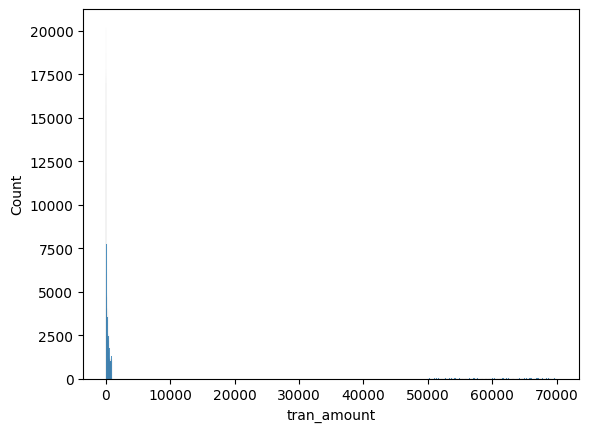

In [380]:
sns.histplot(df_tran.tran_amount)

<Axes: xlabel='tran_amount', ylabel='Count'>

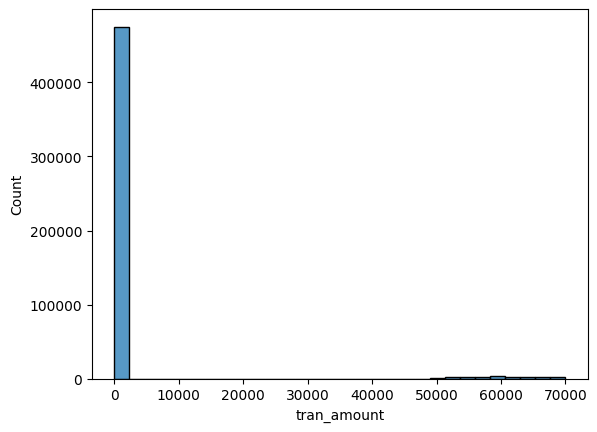

In [381]:
sns.histplot(df_tran.tran_amount,bins = 30)

<Axes: xlabel='tran_amount', ylabel='Count'>

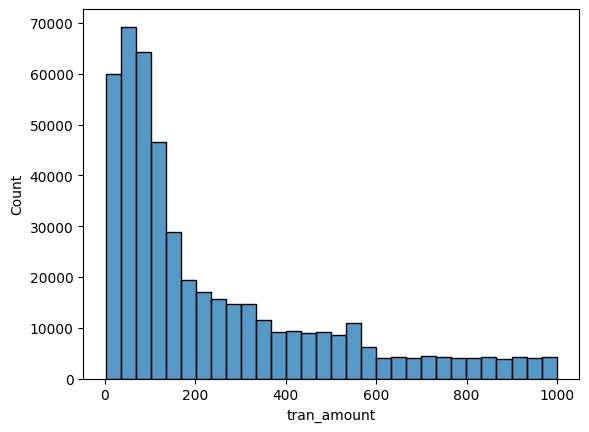

In [389]:
sns.histplot(df_tran[df_tran.tran_amount<1000].tran_amount,bins = 30)

In [391]:
Q1,Q2,Q3 = round(df_tran['tran_amount'].quantile([0.25,0.5,0.75]),2)

In [392]:
Q1,Q2,Q3

(66.0, 146.0, 413.0)

In [397]:
IQR = round(Q3-Q1,2)
lower_limit = Q1 - 2*IQR
upper_limit = Q3 + 2*IQR ### we can tweak these 
lower_limit, upper_limit

(-628.0, 1107.0)

In [398]:
outlier_1 = df_tran[df_tran['tran_amount']<lower_limit] 
outlier_2 = df_tran[df_tran['tran_amount']>upper_limit]

In [399]:
outlier_1,outlier_2 

(Empty DataFrame
 Columns: [tran_id, cust_id, tran_date, tran_amount, platform, product_category, payment_type]
 Index: [],
         tran_id  cust_id   tran_date  tran_amount  platform  \
 26           27      380  2023-01-01        61963   Shopify   
 49           50      287  2023-01-01        57869    Amazon   
 94           95      770  2023-01-01        52881      Ebay   
 104         105      549  2023-01-01        58574  Flipkart   
 113         114      790  2023-01-01        51669   Shopify   
 ...         ...      ...         ...          ...       ...   
 499742   499743      868  2023-09-05        55131    Meesho   
 499888   499889      614  2023-09-05        59679    Meesho   
 499900   499901      811  2023-09-05        60184  Flipkart   
 499966   499967      662  2023-09-05        54678    Meesho   
 499996   499997      569  2023-09-05        53022    Meesho   
 
               product_category payment_type  
 26      Beauty & Personal Care  Credit Card  
 49         

In [400]:
df_tran[df_tran['tran_amount']>upper_limit]

,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type
26,27,380,2023-01-01,61963,Shopify,Beauty & Personal Care,Credit Card
49,50,287,2023-01-01,57869,Amazon,Toys & Games,Gpay
94,95,770,2023-01-01,52881,Ebay,Kitchen Appliances,Credit Card
104,105,549,2023-01-01,58574,Flipkart,Fashion & Apparel,Gpay
113,114,790,2023-01-01,51669,Shopify,Kitchen Appliances,Credit Card
...,...,...,...,...,...,...,...
499742,499743,868,2023-09-05,55131,Meesho,Fashion & Apparel,Gpay
499888,499889,614,2023-09-05,59679,Meesho,Fashion & Apparel,Net Banking
499900,499901,811,2023-09-05,60184,Flipkart,Sports,Debit Card
499966,499967,662,2023-09-05,54678,Meesho,Sports,Gpay


In [402]:
outlier_1.shape

(0, 7)

In [403]:
outlier_2.shape

(25000, 7)

In [404]:
df_tran_normal = df_tran[df_tran['tran_amount']<upper_limit]

In [407]:
tran_mean_per_category = df_tran_normal.groupby('product_category').tran_amount.median()

In [412]:
tran_mean_per_category

product_category
Beauty & Personal Care     92.0
Books                      30.0
Electronics               529.0
Fashion & Apparel          65.0
Garden & Outdoor          126.0
Home Decor                305.0
Kitchen Appliances        176.0
Sports                    269.0
Toys & Games               50.0
Name: tran_amount, dtype: float64

In [409]:
df_tran.loc[outlier_2.index,'tran_amount'] = outlier_2['product_category'].map(tran_mean_per_category)

In [410]:
df_tran.head()

,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type
0,1,705,2023-01-01,63,Flipkart,Electronics,Phonepe
1,2,385,2023-01-01,99,Alibaba,Fashion & Apparel,Credit Card
2,3,924,2023-01-01,471,Shopify,Sports,Phonepe
3,4,797,2023-01-01,33,Shopify,Fashion & Apparel,Gpay
4,5,482,2023-01-01,68,Amazon,Fashion & Apparel,Net Banking


In [411]:
df_tran.loc[[26,49,94,104]]

,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type
26,27,380,2023-01-01,92,Shopify,Beauty & Personal Care,Credit Card
49,50,287,2023-01-01,50,Amazon,Toys & Games,Gpay
94,95,770,2023-01-01,176,Ebay,Kitchen Appliances,Credit Card
104,105,549,2023-01-01,65,Flipkart,Fashion & Apparel,Gpay


<Axes: xlabel='tran_amount', ylabel='Count'>

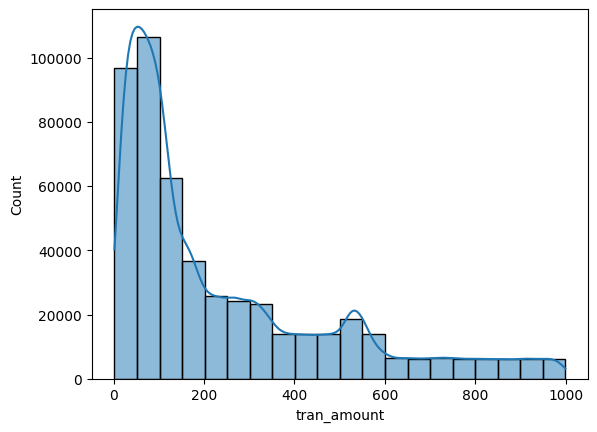

In [413]:
sns.histplot(df_tran.tran_amount,kde=True,bins=20)

<Axes: xlabel='payment_type', ylabel='percent'>

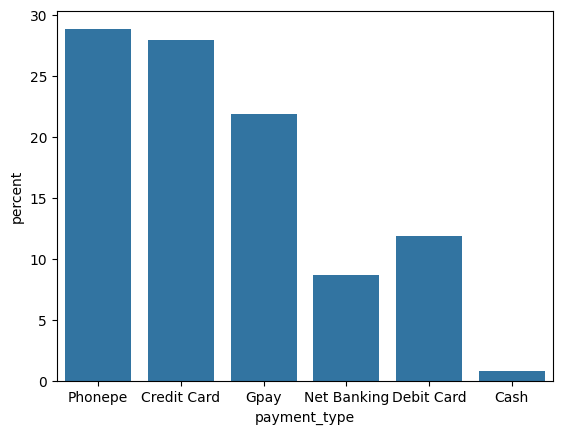

In [417]:
sns.countplot(x=df_tran.payment_type,stat='percent')

In [418]:
df_merge.head()

,cust_id,name,gender,age,location,occupation,annual_income,marital_status,age_group,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_score_labels,credit_limit_mode
0,1,Manya Acharya,Female,51.0,City,Business Owner,358211.0,Married,49-80 group,749,0.585171,19571.0,0.0,40000.0,[700-749],40000.0
1,2,Anjali Pandey,Female,47.0,City,Consultant,65172.0,Single,36-48 group,587,0.107928,1250.0,2.0,1250.0,[550-599],1250.0
2,3,Aaryan Chauhan,Male,21.0,City,Freelancer,22378.0,Married,18-25 group,544,0.854807,513.0,4.0,1000.0,[500-549],1000.0
3,4,Rudra Bali,Male,24.0,Rural,Freelancer,33563.0,Married,18-25 group,504,0.336938,224.0,2.0,1000.0,[500-549],1000.0
4,5,Advait Malik,Male,48.0,City,Consultant,39406.0,Married,36-48 group,708,0.586151,18090.0,2.0,40000.0,[700-749],40000.0


In [419]:
df_merge2 = df_merge.merge(df_tran,on = "cust_id", how = "inner")

In [423]:
df_merge2.head()
df_merge2.shape

(500000, 22)

<Axes: xlabel='age_group', ylabel='count'>

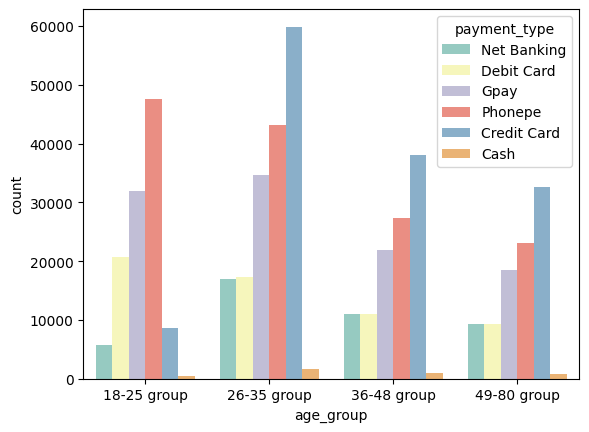

In [425]:
sns.countplot(x= "age_group", hue = "payment_type",data = df_merge2 ,palette = 'Set3')

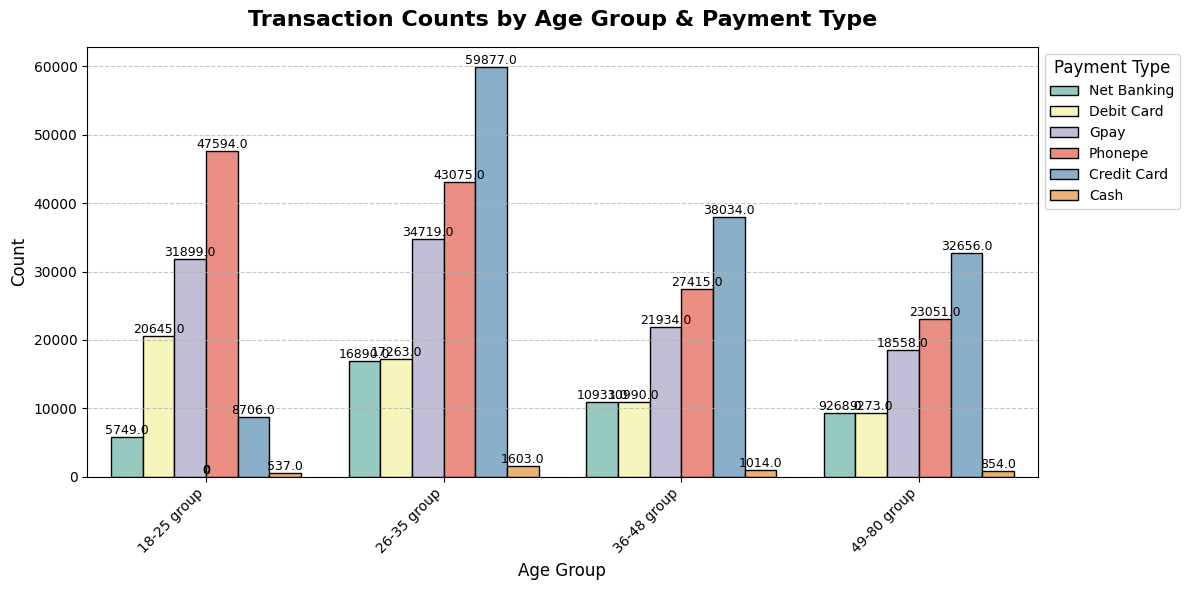

In [426]:
plt.figure(figsize=(12, 6))

ax = sns.countplot(
    x="age_group",
    hue="payment_type",
    data=df_merge2,
    palette="Set3",
    edgecolor="black",
    linewidth=1
)

# Title and axis labels
ax.set_title("Transaction Counts by Age Group & Payment Type", fontsize=16, fontweight="bold", pad=15)
ax.set_xlabel("Age Group", fontsize=12)
ax.set_ylabel("Count", fontsize=12)

# Rotate x‑labels for readability
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=10)

# Add grid lines (only horizontal)
ax.yaxis.grid(True, linestyle="--", alpha=0.7)
ax.xaxis.grid(False)

# Move legend outside the plot
ax.legend(title="Payment Type", title_fontsize=12, fontsize=10, loc="upper left", bbox_to_anchor=(1, 1))

# Annotate bars with their count
for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f"{height}",
        (p.get_x() + p.get_width() / 2, height),
        ha="center", va="bottom",
        fontsize=9
    )

plt.tight_layout()
plt.show()

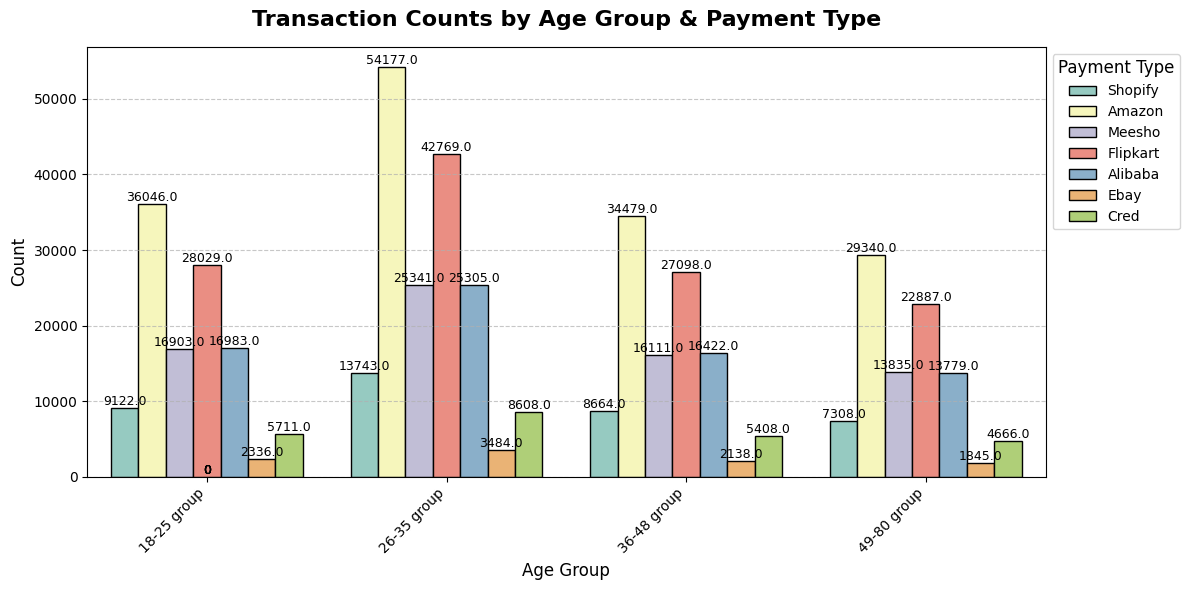

In [427]:
plt.figure(figsize=(12, 6))

ax = sns.countplot(
    x="age_group",
    hue="platform",
    data=df_merge2,
    palette="Set3",
    edgecolor="black",
    linewidth=1
)

# Title and axis labels
ax.set_title("Transaction Counts by Age Group & Payment Type", fontsize=16, fontweight="bold", pad=15)
ax.set_xlabel("Age Group", fontsize=12)
ax.set_ylabel("Count", fontsize=12)

# Rotate x‑labels for readability
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=10)

# Add grid lines (only horizontal)
ax.yaxis.grid(True, linestyle="--", alpha=0.7)
ax.xaxis.grid(False)

# Move legend outside the plot
ax.legend(title="Payment Type", title_fontsize=12, fontsize=10, loc="upper left", bbox_to_anchor=(1, 1))

# Annotate bars with their count
for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f"{height}",
        (p.get_x() + p.get_width() / 2, height),
        ha="center", va="bottom",
        fontsize=9
    )

plt.tight_layout()
plt.show()

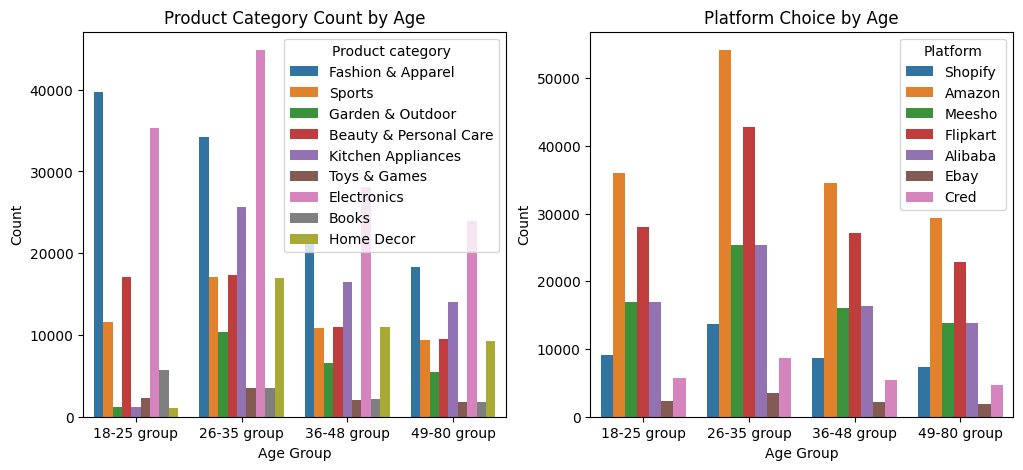

In [431]:
fig,(ax1 ,ax2) = plt.subplots(1,2,figsize=(12,5))
sns.countplot(x='age_group', hue="product_category",data=df_merge2,ax=ax1)
ax1.set_title("Product Category Count by Age")
ax1.set_xlabel("Age Group")
ax1.set_ylabel("Count")
ax1.legend(title="Product category", loc = 'upper right')
sns.countplot(x='age_group', hue="platform",data=df_merge2,ax=ax2)
ax2.set_title("Platform Choice by Age")
ax2.set_xlabel("Age Group")
ax2.set_ylabel("Count")
ax2.legend(title="Platform", loc = 'upper right')

# Business Analysis and launch of AB testing: Targeting Untapped Market

## Insights specific to customers with age group of 18 - 25
1. People with age group of 18 -25 accounts to ~25% of customer base in the data
2. Avg annual income of this age group is less than 50k
3. They don't have much credit history which is getting reflected in their credit score and max credit limit 
4. Usage of credit cards as payment type is relatively low compared to other groups
5. Avg transaction amount made with credit cards is also low compared to other groups
5. Top 3 most used shopping products categories  : Electronics, Fashion & Apparel, Beauty & Personal care

![Analysis Image](analysis.png)

## (1) Pre-Campaign

We want to do a trial run for our new credit card. For this we need to figure out (1) How many customers do we need for our A/B testing. We will form a control and test group. For both of these groups we can figure out number of customers we need based on the statistical power and effect size that we agree upon after discussing with business. We will use 

In [3]:
#import required libraries
import statsmodels.stats.api as sms
import statsmodels.api as sm
import pandas as pd
import numpy as np
from scipy import stats as st
from matplotlib import pyplot as plt
import seaborn as sns

In [4]:
alpha = 0.05
power = 0.8
effect_size =  0.2

In [5]:
sms.tt_ind_solve_power(effect_size=effect_size, alpha= alpha,
                       power= power, ratio=1.0, alternative='two-sided') 


393.40569300025135

In [6]:
effect_sizes = [0.1,0.2,0.3,0.4,0.5,1]
for effect_size in effect_sizes:
    sample_size = sms.tt_ind_solve_power(effect_size=effect_size, alpha= alpha,
                       power= power, ratio=1.0, alternative='two-sided') 
    print('effect_szie = ',effect_size,' ',sample_size)

effect_szie =  0.1   1570.7330430520024
effect_szie =  0.2   393.40569300025135
effect_szie =  0.3   175.38466947045717
effect_szie =  0.4   99.08032514658997
effect_szie =  0.5   63.765610587854006
effect_szie =  1   16.71472244695401


Based on business requirements, the test should be capable of detecting a minimum 0.4 standard deviation difference between the control and test groups. For the effect size 0.4, we need 100 customers and when we discussed with business, 100 customers is ok in terms of their budgeting constraints for this trail run

#### Forming control and test groups

1.We have identified approximately 246 customers within the age group of 18 to 25. From this pool, we will select 100 customers for the initial campaign launch.

2.The campaign is launched for 100 customers, as determined by the effective size calculation and by considering budgeting costs, and will run campaign for a duration of 2 months

3.Got a conversion rate of ~40% ( implies 40 out of 100 customers in test group started using credit card)

4.To maintain a similar sample size, a control group consisting of 40 customers will be created. Importantly, this control group will be completely exclusive of initial 100 customers used as test group.

5.So now we have 40 customers in each of control and test groups

#### At the end of the 2-month campaign period (from 09-10-23 to 11-10-23), we obtained daily data showing the average transaction amounts made by the entire group of 40 customers in both the control and test groups using existing and newly launched credit cards respectively

##### The key performance indicator (KPI) for this AB test aims to enhance average transaction amounts facilitated by the new card

In [9]:
df_after_campaign = pd.read_csv('avg_transactions_after_campaign.csv')

In [10]:
df_after_campaign.head()

,campaign_date,control_group_avg_tran,test_group_avg_tran
0,2023-09-10,259.83,277.32
1,2023-09-11,191.27,248.68
2,2023-09-12,212.41,286.61
3,2023-09-13,214.92,214.85
4,2023-09-14,158.55,344.08


In [11]:
df_after_campaign.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   campaign_date           62 non-null     object 
 1   control_group_avg_tran  62 non-null     float64
 2   test_group_avg_tran     62 non-null     float64
dtypes: float64(2), object(1)
memory usage: 1.6+ KB


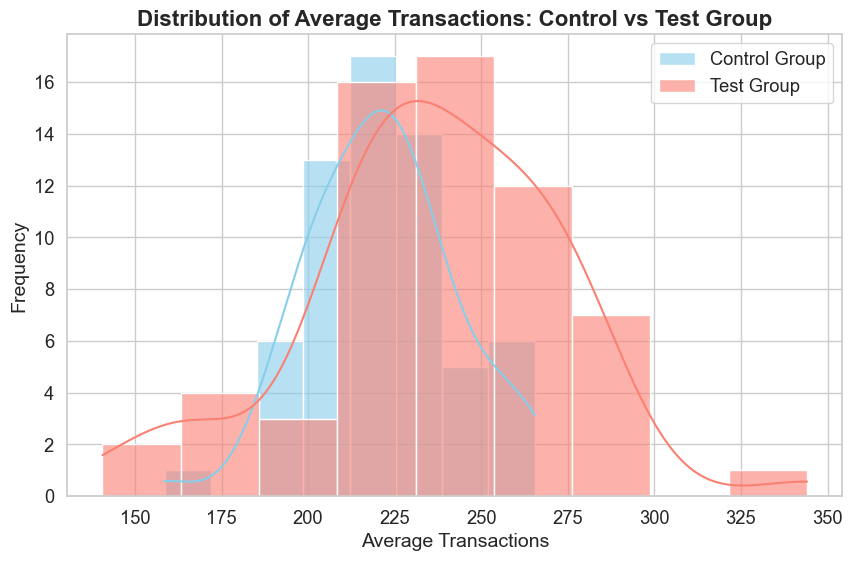

In [12]:
# Set style
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

# Plot
plt.figure(figsize=(10, 6))
sns.histplot(df_after_campaign['control_group_avg_tran'], 
             color='skyblue', label='Control Group', kde=True, alpha=0.6)
sns.histplot(df_after_campaign['test_group_avg_tran'], 
             color='salmon', label='Test Group', kde=True, alpha=0.6)

# Labels & Title
plt.xlabel("Average Transactions", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title("Distribution of Average Transactions: Control vs Test Group", fontsize=16, weight='bold')
plt.legend()

# Show plot
plt.show()

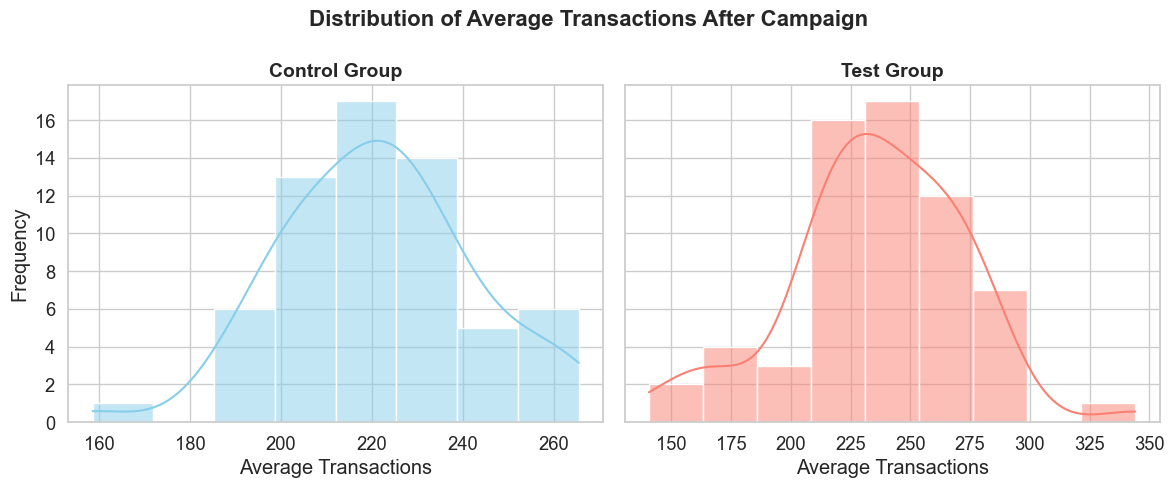

In [16]:


# Set style
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Control group histogram
sns.histplot(df_after_campaign['control_group_avg_tran'], 
             color='skyblue', kde=True, ax=axes[0])
axes[0].set_title("Control Group", fontsize=14, weight='bold')
axes[0].set_xlabel("Average Transactions")
axes[0].set_ylabel("Frequency")

# Test group histogram
sns.histplot(df_after_campaign['test_group_avg_tran'], 
             color='salmon', kde=True, ax=axes[1])
axes[1].set_title("Test Group", fontsize=14, weight='bold')
axes[1].set_xlabel("Average Transactions")

# Adjust layout
plt.suptitle("Distribution of Average Transactions After Campaign", fontsize=16, weight='bold')
plt.tight_layout()
plt.show()

In [17]:
df_after_campaign[df_after_campaign['control_group_avg_tran'] < df_after_campaign['test_group_avg_tran']]

,campaign_date,control_group_avg_tran,test_group_avg_tran
0,2023-09-10,259.83,277.32
1,2023-09-11,191.27,248.68
2,2023-09-12,212.41,286.61
4,2023-09-14,158.55,344.08
5,2023-09-15,262.63,266.86
6,2023-09-16,228.06,260.91
7,2023-09-17,197.02,236.21
10,2023-09-20,229.45,233.24
11,2023-09-21,206.65,210.10
12,2023-09-22,222.34,247.89


In [18]:
df_after_campaign[df_after_campaign['control_group_avg_tran'] < df_after_campaign['test_group_avg_tran']].shape

(44, 3)

In [19]:
df_after_campaign[df_after_campaign['control_group_avg_tran'] > df_after_campaign['test_group_avg_tran']].shape[0]

18

In [20]:
df_after_campaign[df_after_campaign['control_group_avg_tran'] > df_after_campaign['test_group_avg_tran']].shape

(18, 3)

In [21]:
df_after_campaign[df_after_campaign['control_group_avg_tran'] > df_after_campaign['test_group_avg_tran']].shape[0]/df_after_campaign.shape[0]

0.2903225806451613

In [22]:
# our test group is performing better for 71%

In [24]:
control_mean = df_after_campaign['control_group_avg_tran'].mean().round(2)
control_std = df_after_campaign['control_group_avg_tran'].std().round(2)
control_mean, control_std

(np.float64(221.18), np.float64(21.36))

In [25]:
test_mean = df_after_campaign['test_group_avg_tran'].mean().round(2)
test_std = df_after_campaign['test_group_avg_tran'].std().round(2)
test_mean, test_std

(np.float64(235.98), np.float64(36.66))

In [27]:
sample_size = df_after_campaign.shape[0]

In [28]:
sample_size

62

In [30]:
a = test_std** 2 /sample_size
b = control_std** 2/sample_size
a , b

(np.float64(21.67670322580645), np.float64(7.3588645161290325))

In [31]:
z_score = (test_mean - control_mean)/np.sqrt(a+b)

In [32]:
z_score

np.float64(2.7466072001806734)

In [33]:
z_crit = st.norm.ppf(1-alpha)
z_score , z_crit

(np.float64(2.7466072001806734), np.float64(1.6448536269514722))

In [34]:
z_score > z_crit

np.True_

In [35]:
# new credit card is working

Since Z score is higher than critical Z value, we can reject the null hypothesis.